In [1]:
%reload_ext autoreload
%autoreload 2
# 数据获取
import polars as pl
import plotly
import datetime as dt
import pandas as pd
import math
from scipy import stats
from gq_stock.dataclass import Interval
from gq_stock import FactorStrategy
from gq_stock.dataclass import Interval, PriceType, WeightType
from gq_stock import factor_operation as fo
from gq_stock import weight_limit as wl
import gq_stock as gs
import datetime as dt
from datetime import datetime, timedelta, time
gs.login("", "")
# 数据时间
now = dt.datetime.now()
start_date = dt.date(2021, 1, 1)
end_date = dt.date(2022, 11, 30) 
#end_date = now.date()-dt.timedelta(days=1)
engine = gs.StockEngine(
    start_date = start_date,
    end_date = end_date,
)
ctx = engine.build_context()


[gq-stock version]: 0.3.9
SELECT db_code, db_code_source, coll_code, coll_code_source, status,  FROM table_mapping WHERE 1=1 
SELECT code_old, code_new,  FROM code_change WHERE 1=1 
SELECT db_code, db_code_source, coll_code, coll_code_source, status,  FROM table_mapping WHERE 1=1 
SELECT code_old, code_new,  FROM code_change WHERE 1=1 
SELECT db_code, db_code_source, coll_code, coll_code_source, status,  FROM table_mapping WHERE 1=1 
SELECT code_old, code_new,  FROM code_change WHERE 1=1 
SELECT db_code, db_code_source, coll_code, coll_code_source, status,  FROM table_mapping WHERE 1=1 
SELECT code_old, code_new,  FROM code_change WHERE 1=1 
SELECT db_code, db_code_source, coll_code, coll_code_source, status,  FROM table_mapping WHERE 1=1 
SELECT code_old, code_new,  FROM code_change WHERE 1=1 
SELECT db_code, db_code_source, coll_code, coll_code_source, status,  FROM table_mapping WHERE 1=1 
SELECT code_old, code_new,  FROM code_change WHERE 1=1 
SELECT db_code, db_code_source, coll_c

In [2]:

def cal_rskew(ctx, start_date, end_date):
    import polars as pl
    stock_data = ctx.m.get_bar(
        interval=Interval.M1, 
        start_date=start_date, 
        end_date=end_date, 
    ).sort(["code", "trading_date", "datetime"])
    
    # 市值数据（注意：需确保市值数据与rskew数据的[code, trading_date]完全匹配）
    market_val = ctx.info.get_mkt_val(
        start_date=start_date, 
        end_date=end_date, 
        fields=['code', 'trading_date', 'mv_A_free_float']
    ).with_columns(
        # 市值取对数（符合金融数据常见处理，减少极端值影响）
        log_mv = pl.col("mv_A_free_float").log()
    ).drop("mv_A_free_float")  # 保留对数市值用于回归

    # 1. 计算分钟对数收益并过滤空值
    df_with_r = stock_data.sort(["code", "trading_date", "datetime"]).with_columns(
        r = pl.col("close").log() - pl.col("close").log().shift(1),
    ).filter(pl.col("r").is_not_null())

    # 2. 按股票+交易日分组，计算当日原始rskew
    daily_rskew = df_with_r.group_by(["code", "trading_date"]).agg(
        r_mean = pl.col("r").mean(),
        r_count = pl.col("r").count(),
        r_sum_sq = ((pl.col("r") - pl.col("r").mean()) ** 2).sum(),
        r_sum_cu = ((pl.col("r") - pl.col("r").mean()) ** 3).sum(),
    ).with_columns(
        rskew = (pl.col("r_count").sqrt() * pl.col("r_sum_cu")) / (pl.col("r_sum_sq") ** 1.5),
    ).filter(
        pl.col("r_count") >= 30,  # 过滤有效分钟数不足的交易日
        pl.col("r_sum_sq") != 0    # 避免除以0
    ).select("code", "trading_date", "r_count", "rskew")

    # ===================== 修正：3. 市值中性化（用map_groups替代apply） =====================
    # 3.1 关联市值数据（确保每个[code, trading_date]都有市值）
    daily_rskew_with_mv = daily_rskew.join(
        market_val, 
        on=["code", "trading_date"], 
        how="inner"  # 只保留有市值数据的样本，避免空值
    )

    # 3.2 定义分组内回归函数（供map_groups调用）
    def neutralize_by_mv(df: pl.DataFrame,x_column='rskew',y_column='log_mv') -> pl.DataFrame:
        """按交易日分组，对rskew做市值中性化（线性回归取残差）"""
        # 跳过单样本分组（无法回归）
        if len(df) <= 1:
            return df.with_columns(resid=pl.lit(0.0))
        
        # 拟合线性回归：rskew ~ log_mv
        try:
            model = pl.lm(pl.col(x_column), pl.col(y_column), data=df)
            a, b = model.params  # 截距a，斜率b
            # 计算残差（中性化后因子）
            df = df.with_columns(
                resid = pl.col(x_column) - (a + b * pl.col(y_column))
            )
        except:
            # 回归失败时（如log_mv全相同），残差等于原始rskew
            df = df.with_columns(resid=pl.col(x_column))
        return df

    # 3.3 按交易日分组执行中性化（Polars正确用法：map_groups）
    daily_rskew_neutral = daily_rskew_with_mv.group_by("trading_date").map_groups(
        neutralize_by_mv,
        # 显式指定输出schema（提升性能，避免Polars自动推断）
        schema={
            "code": pl.Utf8,
            "trading_date": pl.Date,  # 需匹配你的trading_date类型（如Datetime则改pl.Datetime）
            "r_count": pl.Int64,
            "rskew": pl.Float64,
            "log_mv": pl.Float64,
            "resid": pl.Float64
        }
    ).select(
        "code", "trading_date", "r_count", "rskew", "resid"  # 保留核心列
    )

    # ===================== 4. 标准化（基于中性化后的残差rskew_resid） =====================
    daily_stats = daily_rskew_neutral.group_by("trading_date").agg(
        rskew_mean = pl.col("resid").mean(),  # 用中性化后的均值
        rskew_std = pl.col("resid").std(),    # 用中性化后的标准差
    )

    daily_rskew = daily_rskew_neutral.join(daily_stats, on="trading_date", how="left").with_columns(
        # 标准化中性化后的因子（避免原始因子量级干扰）
        rskew_standard = pl.when(pl.col("rskew_std") != 0)
        .then((pl.col("resid") - pl.col("rskew_mean")) / pl.col("rskew_std"))
        .otherwise(0)
    ).filter(
        pl.col("rskew_standard").abs() <= 3  # 过滤3倍σ极值
    ).select(
        "code", "trading_date", "r_count", "rskew", "resid", "rskew_standard"
    ).sort(["code", "trading_date"])

    return daily_rskew

daily_rskew = cal_rskew(ctx,start_date,end_date)

SELECT db_code, db_code_source, coll_code, coll_code_source, status,  FROM table_mapping WHERE 1=1 
SELECT * FROM L2_m1 WHERE 1=1  AND (1=1)  AND (trading_date between '2021-01-01' and '2022-11-30')
SELECT db_code, db_code_source, coll_code, coll_code_source, status,  FROM table_mapping WHERE 1=1 
SELECT * FROM code_change WHERE 1=1 
[timing loading]: RawSqlHttp { table: "stock_info_data", select: "SELECT * FROM code_change WHERE 1=1 " }
6.556014ms
SELECT db_code, db_code_source, coll_code, coll_code_source, status,  FROM table_mapping WHERE 1=1 
SELECT code, trading_date, mv_A_free_float,  FROM JY_mkt_info WHERE 1=1  AND (1=1)  AND (trading_date between '2021-01-01' and '2022-11-30')


TypeError: GroupBy.map_groups() got an unexpected keyword argument 'schema'

In [ ]:
# 计算下期收益(下个月收益)
day_data = ctx.m.get_bar(interval=Interval.D1, start_date=start_date, end_date=end_date)
day_data = day_data.with_columns(
    (pl.col('close')*pl.col('adj')).alias('close')
)

# 1.提取月份数据
monthly_data = day_data.group_by(
    "code",
    pl.col("trading_date").dt.strftime("%Y-%m").alias("year_month")  # 按年月分组
).agg(
    pl.col("trading_date").last().alias("month_end_date"),  # 月末日期
    pl.col("close").last().alias("month_end_close")       # 月末收盘价
).sort(["code", "year_month"])  # 确保年月升序

# 2.按股票分组计算下期收益
monthly_data = monthly_data.with_columns(
    # 下月收盘价：向下位移1行（当前行的下一行是下月）
    pl.col("month_end_close").shift(-1).over("code").alias("next_month_close"),
    # 下月年月：用于核对
    pl.col("year_month").shift(-1).over("code").alias("next_year_month")
)
# 计算下期收益（(下月收盘价 - 当月收盘价)/当月收盘价）
monthly_data = monthly_data.with_columns(
    pl.when(pl.col("next_month_close").is_not_null())  # 排除最后一个月（无下月）
    .then((pl.col("next_month_close") - pl.col("month_end_close")) / pl.col("month_end_close"))
    .otherwise(None)
    .alias("next_month_return")  # 下期（下月）收益率
)

# 3.合并到日线数据
# 为原始数据添加「年-月」字段
day_data = day_data.with_columns(
    pl.col("trading_date").dt.strftime("%Y-%m").alias("year_month")
)

# 关联月度收益到日度数据
day_data_with_return = day_data.join(
    monthly_data.select(["code", "year_month", "next_month_return"]),
    on=["code", "year_month"],
    how="left"
)


SELECT db_code, db_code_source, coll_code, coll_code_source, status,  FROM table_mapping WHERE 1=1 
SELECT * FROM JY_d WHERE 1=1  AND (1=1)  AND (trading_date between '2021-01-01' and '2021-11-30')


In [ ]:
merged_data = day_data_with_return.join(
    daily_rskew.select(["code", "trading_date", "rskew_standard"]),
    on=["code", "trading_date"],
    how="left"
)
merged_data

code,underlying,trading_date,datetime,pre_close,open,high,low,close,limit_up,limit_down,volume,turnover,pct,adj,vwap,year_month,next_month_return,rskew_standard
str,str,date,"datetime[ms, Asia/Shanghai]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64
"""SHSE.600000""","""stock""",2021-06-11,2021-06-11 16:00:00 CST,10.23,10.24,10.28,10.11,10.17,11.25,9.21,5.8030252e7,5.91098496e8,-0.59,13.415432,10.19,"""2021-06""",-0.029326,-0.053568
"""SHSE.600004""","""stock""",2021-06-11,2021-06-11 16:00:00 CST,11.85,11.7,11.79,11.56,11.69,13.04,10.67,4.0387204e7,4.70938848e8,-1.35,2.607464,11.66,"""2021-06""",-0.059025,-1.566461
"""SHSE.600006""","""stock""",2021-06-11,2021-06-11 16:00:00 CST,8.12,8.11,8.11,7.8,7.95,8.93,7.31,1.0806932e8,8.58684672e8,-2.09,3.677167,7.95,"""2021-06""",-0.058215,-0.087865
"""SHSE.600007""","""stock""",2021-06-11,2021-06-11 16:00:00 CST,18.8,18.5,19.21,17.52,19.08,20.68,16.92,1.3515887e7,2.47147888e8,1.49,1.845155,18.29,"""2021-06""",-0.149414,-0.531105
"""SHSE.600008""","""stock""",2021-06-11,2021-06-11 16:00:00 CST,3.05,3.04,3.07,3.03,3.03,3.36,2.75,4.1905352e7,1.27759456e8,-0.66,8.531953,3.05,"""2021-06""",-0.038585,-0.159864
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SZSE.300925""","""stock""",2021-01-08,2021-01-08 16:00:00 CST,58.09,57.51,67.7,54.7,64.98,69.71,46.47,1.5017656e7,9.22261568e8,11.86,1.0,61.41,"""2021-01""",-0.391659,-0.211257
"""SZSE.300926""","""stock""",2021-01-08,2021-01-08 16:00:00 CST,31.15,28.13,32.8,27.12,30.01,37.38,24.92,1.6753122e7,4.98644e8,-3.66,1.0,29.76,"""2021-01""",-0.28024,-1.765562
"""SZSE.300927""","""stock""",2021-01-08,2021-01-08 16:00:00 CST,41.23,40.0,50.29,39.22,46.49,49.48,32.98,1.3076749e7,5.84142528e8,12.76,1.0,44.67,"""2021-01""",-0.360508,0.24646


因子IC分析结果
因子名称: rskew_standard
平均IC: 0.0664
IC标准差: 0.0765
IC信息比率(IR): 0.8673
正IC占比: 78.28%
有效交易日数量: 198

因子分组收益统计 (按因子值从低到高分组)
shape: (10, 4)
┌──────────────┬──────────────────┬─────────────────┬──────────────┐
│ factor_group ┆ mean_next_return ┆ std_next_return ┆ sharpe_ratio │
│ ---          ┆ ---              ┆ ---             ┆ ---          │
│ i32          ┆ f64              ┆ f64             ┆ f64          │
╞══════════════╪══════════════════╪═════════════════╪══════════════╡
│ 1            ┆ 0.006493         ┆ 0.290563        ┆ 0.35475      │
│ 2            ┆ -0.00449         ┆ 0.045768        ┆ -1.557293    │
│ 3            ┆ -0.002307        ┆ 0.044284        ┆ -0.827079    │
│ 4            ┆ 0.000955         ┆ 0.044705        ┆ 0.339023     │
│ 5            ┆ 0.002353         ┆ 0.04713         ┆ 0.792618     │
│ 6            ┆ 0.003376         ┆ 0.047035        ┆ 1.139524     │
│ 7            ┆ 0.007475         ┆ 0.048015        ┆ 2.471263     │
│ 8            ┆ 0.011993      

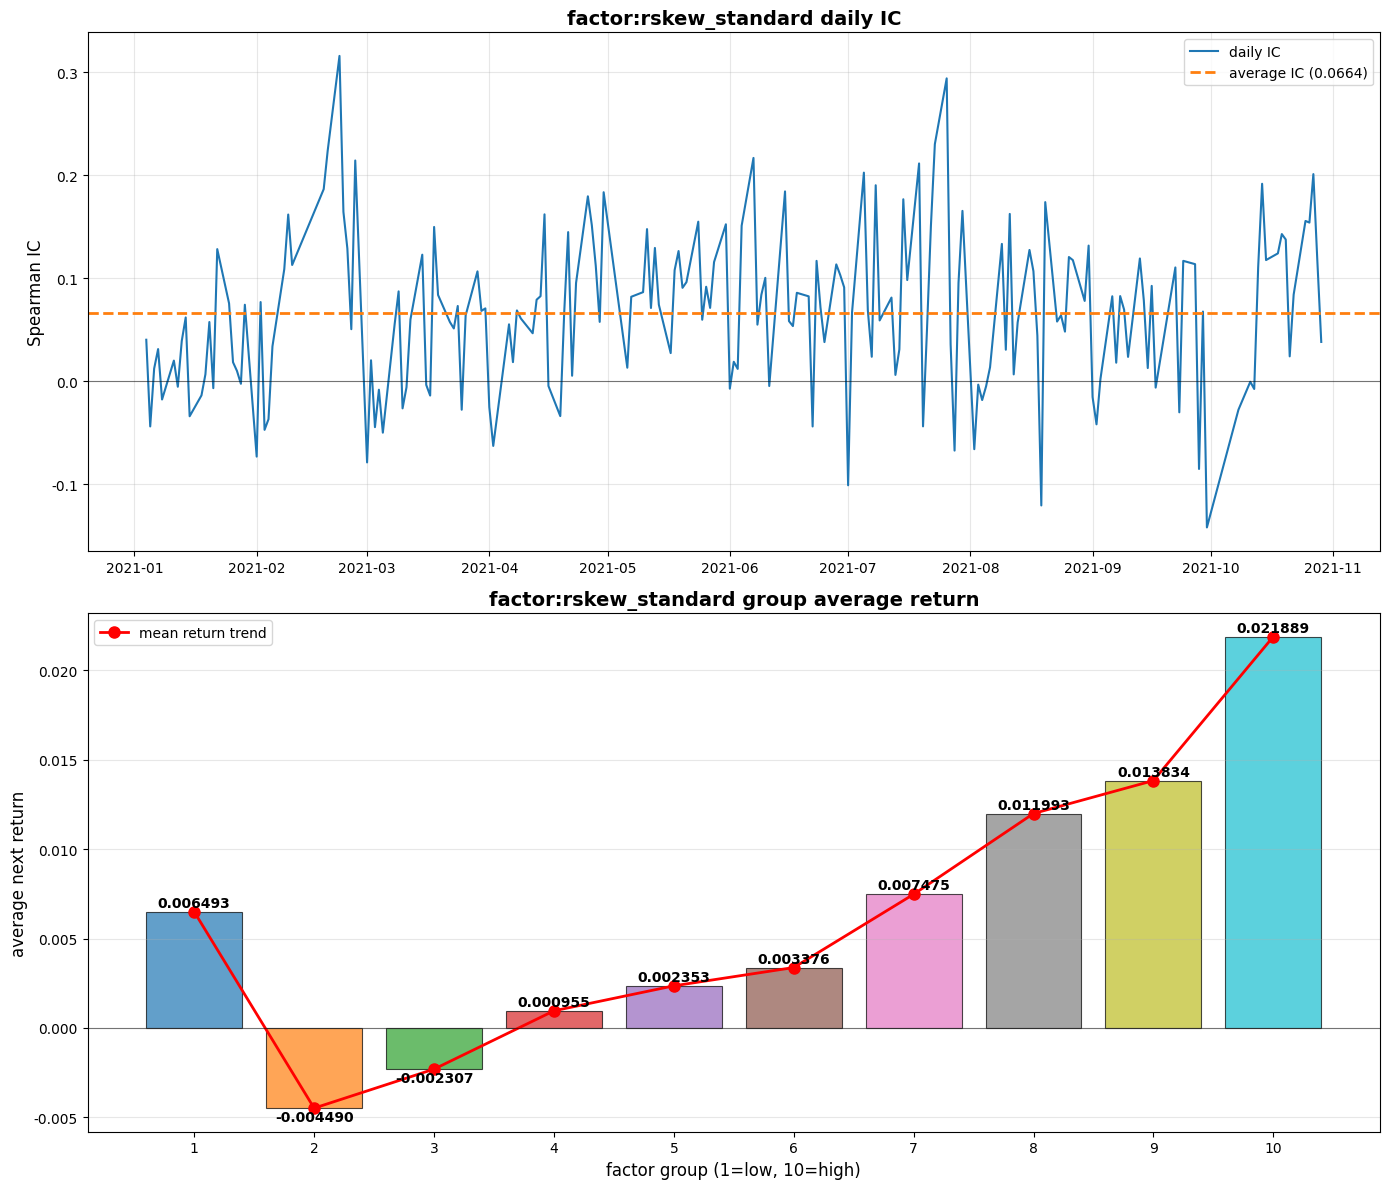

In [ ]:

import numpy as np
# 因子分析函数
def factor_analysis(
    merged_data: pl.DataFrame,
    factor_column: str,
    next_column: str,
    group_num: int = 5
) -> pl.DataFrame:  # 明确返回类型为Polars DataFrame
    """
    因子分析函数：计算IC、分组收益，并绘制IC折线图和分组平均收益折线图
    
    参数：
    --------
    merged_data : pl.DataFrame
        包含因子列、下期收益列、code（股票代码）、trading_date（交易日期）的DataFrame
    factor_column : str
        因子列名（如示例中的rskew_standard）
    next_column : str
        下期收益列名
    group_num : int, 可选
        分组数量（默认5组）
    
    返回：
    --------
    pl.DataFrame
        分组收益统计结果（mean_next_return/std_next_return）
    """
    import polars as pl
    import numpy as np
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings('ignore')

    # 设置中文字体（可选，根据需要调整）
    # plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
    
    # ===================== 数据预处理 =====================
    # 检查必要列是否存在
    required_cols = ["code", "trading_date", factor_column, next_column]
    missing_cols = [col for col in required_cols if col not in merged_data.columns]
    if missing_cols:
        raise ValueError(f"数据缺少必要列：{missing_cols}")
    
    # 去除因子或收益为空的行
    df = merged_data.drop_nulls(subset=[factor_column, next_column])
    
    # 按日期排序
    df = df.sort(["trading_date", "code"])
    
    # ===================== 计算IC系数 =====================
    # 按交易日分组计算因子与下期收益的秩相关系数（IC）
    ic_df = df.group_by("trading_date").agg([
        pl.corr(factor_column, next_column, method="spearman").alias("ic"),
        pl.count().alias("stock_count")  # 记录每日有效股票数量
    ]).sort("trading_date")
    
    # IC统计指标
    ic_mean = ic_df["ic"].mean()
    ic_std = ic_df["ic"].std()
    ic_ir = ic_mean / ic_std if ic_std != 0 else np.nan  # 信息比率
    ic_positive_ratio = (ic_df["ic"] > 0).mean() * 100
    
    # ===================== 因子分组收益分析 =====================
    # 按交易日分组，对因子进行分位数分组（1为最低组，group_num为最高组）
    df_with_group = (
        df
        .with_columns(
            # 在每个交易日组内计算排名
            factor_rank=pl.col(factor_column)
                        .rank(method="min")
                        .over("trading_date"),
            # 计算每个交易日的数据总数
            group_count=pl.col(factor_column)
                        .count()
                        .over("trading_date")
        )
        .with_columns(
            # 计算百分比排名
            factor_pct_rank=(pl.col("factor_rank") - 1) / 
                            (pl.col("group_count") - 1)
        )
        .with_columns(
            # 使用 ceil 函数进行分组
            factor_group=(pl.col("factor_pct_rank") * group_num + 1)
                .clip(1, group_num)
                .ceil()
                .cast(pl.Int32)
        )
        .drop(["factor_rank", "group_count", "factor_pct_rank"])
    )
    
    # 计算每组每日平均收益
    group_daily_return = df_with_group.group_by(["trading_date", "factor_group"]).agg(
        pl.col(next_column).mean().alias("next_return")
    ).sort(["trading_date", "factor_group"])
    
    # 计算分组收益统计
    group_stats = group_daily_return.group_by("factor_group").agg(
        pl.col("next_return").mean().alias("mean_next_return"),
        pl.col("next_return").std().alias("std_next_return"),
        # 可选：恢复夏普比率计算（需确保分母不为0）
        (pl.col("next_return").mean() / pl.col("next_return").std() * np.sqrt(252)).alias("sharpe_ratio")
    ).sort("factor_group")
    
    # ===================== 打印分析结果 =====================
    print("="*80)
    print("因子IC分析结果")
    print("="*80)
    print(f"因子名称: {factor_column}")
    print(f"平均IC: {ic_mean:.4f}")
    print(f"IC标准差: {ic_std:.4f}")
    print(f"IC信息比率(IR): {ic_ir:.4f}")
    print(f"正IC占比: {ic_positive_ratio:.2f}%")
    print(f"有效交易日数量: {len(ic_df)}")
    
    print("\n" + "="*80)
    print("因子分组收益统计 (按因子值从低到高分组)")
    print("="*80)
    print(group_stats)  # 保留6位小数，更清晰
    
    # ===================== 绘制图表 =====================
    # 转换为Pandas（Polars时间序列绘图兼容性更优）
    ic_df_pd = ic_df.to_pandas()
    # 提取分组统计的Pandas数据（用于绘制组-收益图）
    group_stats_pd = group_stats.to_pandas()

    # 创建2行1列的画布（IC图 + 分组平均收益图）
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

    # 1. IC折线图（保留原有逻辑）
    ax1.plot(ic_df_pd["trading_date"], ic_df_pd["ic"], color="#1f77b4", linewidth=1.5, label="daily IC")
    ax1.axhline(y=ic_mean, color="#ff7f0e", linestyle="--", linewidth=2, label=f"average IC ({ic_mean:.4f})")
    ax1.axhline(y=0, color="black", linestyle="-", linewidth=0.8, alpha=0.5)
    ax1.set_title(f"factor:{factor_column} daily IC", fontsize=14, fontweight="bold")
    ax1.set_ylabel("Spearman IC", fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # 2. 分组平均收益图（横坐标=组，纵坐标=平均收益）核心修改
    # 提取x轴（分组）和y轴（平均收益）数据
    groups = group_stats_pd["factor_group"].values  # 分组1~group_num
    mean_returns = group_stats_pd["mean_next_return"].values  # 每组平均收益

    # 绘制柱状图（主）+ 折线图（辅），更直观
    bars = ax2.bar(
        x=groups, 
        height=mean_returns, 
        color=plt.cm.tab10(np.linspace(0, 1, group_num)),  # 分组配色
        alpha=0.7, 
        edgecolor="black", 
        linewidth=0.8
    )
    # 叠加折线图，突出趋势
    ax2.plot(
        groups, 
        mean_returns, 
        color="red", 
        marker="o", 
        markersize=8, 
        linewidth=2, 
        label="mean return trend"
    )

    # 图表美化
    ax2.axhline(y=0, color="black", linestyle="-", linewidth=0.8, alpha=0.5)  # 0收益参考线
    ax2.set_title(f"factor:{factor_column} group average return", fontsize=14, fontweight="bold")
    ax2.set_xlabel("factor group (1=low, {}=high)".format(group_num), fontsize=12)  # 标注分组含义
    ax2.set_ylabel("average next return", fontsize=12)
    ax2.set_xticks(groups)  # 确保x轴仅显示分组数（1,2,...group_num）
    ax2.grid(True, alpha=0.3, axis="y")  # 仅显示y轴网格

    # 在柱状图上方标注具体收益值
    for bar, value in zip(bars, mean_returns):
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width()/2., 
            height + (0.0001 if height >=0 else -0.0001),  # 数值标注位置微调
            f"{value:.6f}", 
            ha="center", va="bottom" if height >=0 else "top", 
            fontsize=10, fontweight="bold"
        )

    ax2.legend(fontsize=10)

    # 调整布局，避免标签重叠
    plt.tight_layout()
    plt.show()
    
    return group_stats

# ===================== 使用示例 =====================
if __name__ == "__main__":

    # 调用因子分析函数
    a=factor_analysis(
        merged_data=merged_data,
        factor_column="rskew_standard",
        next_column="next_month_return",
        group_num=10
    )
    